# Hyper-parameter Optimization with RayTune + RAPIDS

### Introduction

&emsp; &emsp; &emsp; [Hyperparameter optimization](https://cloud.google.com/ai-platform/training/docs/hyperparameter-tuning-overview) is the task of picking the values for the hyperparameters of the model that provide the optimal results for the problem, as measured on a test dataset. This is often a crucial step and can help boost the model performance when done correctly. Despite its theoretical importance, HPO has been difficult to implement in practical applications because of the resources needed to run so many distinct training jobs. In this notebook, we explore the combination of RAPIDS and RayTune to perform HyperOpt on GPU models to understand the importance that selecting the right parameters has on the model performance. We are trying to illustrate that RayTune + RAPIDS can be useful in order to perform HPO in an efficient and practical manner.

#### What is RayTune?

&emsp; &emsp; &emsp; [RayTune](https://ray.readthedocs.io/en/latest/index.html) is a scalable Hyperparameter optimization library. It allows distributed HPO, provides various [search algorithms](https://ray.readthedocs.io/en/latest/tune-searchalg.html) to allow different optimization techniques to be explored with ease. The library also provides [scheduling algorithms](https://ray.readthedocs.io/en/latest/tune-schedulers.html) that allows a smarter way to schedule the different parameter sweep instead of the basic First In-First Out method which is followed by other libraries (Scikit-Learn, Dask-ml) that support HPO. The different scheduling algorithms can make the HPO process resource efficient and help arrive at the best parameters much faster.

#### What is RAPIDS?

&emsp; &emsp; &emsp; The [RAPIDS](https://rapids.ai/start.html) framework provides a library suite that can execute end-to-end data science pipelines entirely on GPUs. One of the libraries in this framework is [cuML](https://docs.rapids.ai/api/cuml/stable/), which contains various Machine Learning algorithms that take advantage of GPU to run. You can learn more about RAPIDS [here](https://rapids.ai/about.html). 

For this demo, we will be using the [Airline dataset](http://kt.ijs.si/elena_ikonomovska/data.html). The aim of the problem is to predict the arrival delay. It has about 116 million entries with 13 attributes that are used to determine the delay for a given airline. We'll demonstrate the use of a cuML [RandomForestClassifier](https://rapidsai.github.io/projects/cuml/en/0.12.0/api.html#cuml.ensemble.RandomForestClassifier) model with RayTune and try to understand how HPO improves the performance, and make a case for why it is useful to perform. 

The notebook is structured as follows:

&emsp; &emsp; &emsp; 1. Loading and preparing the dataset

&emsp; &emsp; &emsp; 2. Setting the experiment parameters (like selecting scheduling & search alg, parameters ranges, etc)

&emsp; &emsp; &emsp; 3. Running and visualizing the results of the experiments

By the end of this notebook, you'll be familiar with running HPO experiments on RayTune with different scheduling algorithms and visualizing the results to study the importance of the process and how it affects the metric used to evaluate the model.

Note: The notebook also includes the scikit-learn RandomForest for the CPU version - this should be used only for the performance comparison and is <b>not</b> recommended with large data size and ranges.

Let's get started with the notebook!

In [1]:
# # Uncomment this line to install the packages
!pip install tabulate nb_black
!pip install -U ray
!pip install ray[tune]
!pip install bayesian-optimization scikit-optimize

Requirement already up-to-date: ray in /opt/conda/envs/rapids/lib/python3.6/site-packages (0.8.4)


In [2]:
%load_ext lab_black

In [3]:
import glob
import logging
import math
import multiprocessing
import os
import subprocess
import sys
import time
from datetime import datetime
from urllib.request import urlretrieve

import cudf
import cuml
import cupy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
from cuml.preprocessing.model_selection import train_test_split
from ray import tune
from ray.tune import track, trial
from ray.tune.logger import TBXLogger
from ray.tune.schedulers import AsyncHyperBandScheduler, MedianStoppingRule
from ray.tune.utils import get_pinned_object, pin_in_object_store

_DEBUG = bool(os.environ.get("_DEBUG", False))

## Parameter Ranges and Base Directory

We define the parameter ranges for the options that we want to explore. The larger the ranges, more likely we will find the "best" parameters. Please take into account the GPU memory constraints while deciding the ranges because for large ranges and rows selected, there might be many failures due to memory issues.

The variable `base_dir` determines where the data will be stored. It is currently set to use the directory the notebook is present in. You may change it if you want.

`search_alg` and `sched_alg` are the options to change the search and scheduling algorithms. We discuss what these algorithms are later in the notebook.

In [4]:
base_dir = os.getcwd()

num_rows = 2500000  # number of rows to be used in this notebook; max: 115000000

# Ensure the dataset is setup
dataset_config = {
    "dataset_name": "airline",
    "nrows": num_rows,  # Max Rows in dataset: 115000000
    "delayed_threshold": 10,
    "remote_URL": "http://kt.ijs.si/elena_ikonomovska/datasets/airline/airline_14col.data.bz2",
    "local_cache_dir": os.path.join(base_dir, "data"),
}

download_filename = os.path.join(
    dataset_config["local_cache_dir"], os.path.basename(dataset_config["remote_URL"])
)
decompressed_filename = os.path.splitext(download_filename)
orc_name = os.path.join(
    dataset_config["local_cache_dir"], "airline" + str(dataset_config["nrows"]) + ".orc"
)

data_dir = dataset_config["local_cache_dir"]

## Prepare Dataset

This ensures that the dataset is present in the local directory specified in `dataset_config['local_cache_dir']`, if not, it downloads and places it in the directory. We will store a copy of the dataset with `num_rows` as an ORC file for faster reading the next time we run the notebook. The path for the ORC file will be determined by `orc_name` specified in earlier.

In [5]:
def prepare_dataset():

    global download_filename, decompressed_filename, orc_name

    if os.path.isfile(orc_name):
        print(f" > File already exists. Ready to load at {orc_name}")
        dataset = cudf.read_orc(orc_name)
        return dataset

    # Ensure folder exists
    os.makedirs(dataset_config["local_cache_dir"], exist_ok=True)

    # download progress tracker
    def data_progress_hook(block_number, read_size, total_filesize):
        if (block_number % 1000) == 0:
            print(
                f" > percent complete: { 100 * ( block_number * read_size ) / total_filesize:.2f}\r",
                end="",
            )
        return

    if not os.path.exists(download_filename):
        print(f"File does not exist, downloading now...")
        urlretrieve(
            url=dataset_config["remote_URL"],
            filename=download_filename,
            reporthook=data_progress_hook,
        )

        print(f" > Download complete {download_filename}")
    else:
        print(f"Dataset already downloaded")

    # Decompressing
    completed = subprocess.run(["bzip2", "-d", download_filename])
    print("returncode:", completed.returncode)

    input_cols = [
        "Year",
        "Month",
        "DayofMonth",
        "DayofWeek",
        "CRSDepTime",
        "CRSArrTime",
        "UniqueCarrier",
        "FlightNum",
        "ActualElapsedTime",
        "Origin",
        "Dest",
        "Distance",
        "Diverted",
        "ArrDelay",
    ]

    # ensure we respect bounds on rows [ airline max = 115 M ]
    nrows = np.min((dataset_config["nrows"], 115000000))

    pdf = pd.read_csv(decompressed_filename[0], names=input_cols, nrows=nrows)
    # turn into binary classification [i.e. flight delays beyond delayed_threshold minutes are considered late ]
    pdf["ArrDelayBinary"] = 1.0 * (
        pdf["ArrDelay"] > dataset_config["delayed_threshold"]
    )

    # drop non-binary label column [ delay time ]
    pdf = pdf[pdf.columns.difference(["ArrDelay"])]

    # encode categoricals as numeric
    for col in pdf.select_dtypes(["object"]).columns:
        pdf[col] = pdf[col].astype("category").cat.codes.astype(np.int32)

    # cast all columns to int32
    for col in pdf.columns:
        pdf[col] = pdf[col].astype(np.float32)  # needed for random forest

    # put target/label column first [ classic XGBoost standard ]
    output_cols = ["ArrDelayBinary"] + input_cols[:-1]

    pdf = pdf.reindex(columns=output_cols)
    cdf = cudf.DataFrame.from_pandas(pdf)
    cdf.to_orc(orc_name)
    return cdf

## Utility Functions and Class

1. `get_trial_name`(function) : Generates the trial name over an iterator variable to store results.

2. `PerfTimer`(class) : A high resolution timer class in order to support the timing of operations to report during the experiment runs.

In [6]:
trial_num = 0


def get_trial_name(trial: ray.tune.trial.Trial):
    # Returns the trial number over an iterator variable trail_num
    global trial_num
    trial_num = trial_num + 1
    trial_name = trial.trainable_name + "_" + str(trial_num)
    return trial_name

In [7]:
class PerfTimer:
    # High resolution timer for reporting training and inference time.
    def __init__(self):
        self.start = None
        self.duration = None

    def __enter__(self):
        self.start = time.perf_counter()
        return self

    def __exit__(self, *args):
        self.duration = time.perf_counter() - self.start

## Setting Up Tune

We will set up the Tune training with the [Trainable API](https://ray.readthedocs.io/en/latest/tune-usage.html#trainable-api) because it is stateful and allows checkpointing, which is useful for complex algorithms.

To do this, let's subclass the `tune.Trainable` class and define the functions for initial setup, training, saving and restoring the models.

### Member functions
1. `_setup` : Load the dataset and set the necessary parameters to config values (uses `_build`)

2. `_train` : Splitting the data into train and test sets, training a CPU or GPU model depending on `compute` mode. Evaluate the model and store the test accuracy. 

3. `_save` and `_restore` : Checkpoint the test accuracy periodically (specified by the scheduling algorithms)

In [8]:
class BaseTrainTransformer(tune.Trainable):
    @property
    def static_config(self) -> dict:
        return getattr(self, "_static_config", {})

    def _setup(self, config: dict):

        CSP_paths = {"train_data": data_dir}
        self._gpu_id = ray.get_gpu_ids()[0]

        self._dataset, self._col_labels, self._y_label = (
            get_pinned_object(data_id),
            None,
            "ArrDelayBinary",
        )

        # classification objective requires int32 label for cuml random forest
        self._dataset[self._y_label] = self._dataset[self._y_label].astype("int32")
        self.rf_model = None
        self._build(config)

    def _build(self, new_config):
        self._model_params = {
            "max_depth": int(new_config["max_depth"]),
            "n_estimators": int(new_config["n_estimators"]),
            "max_features": float(new_config["max_features"]),
            "n_bins": 16,  # args.n_bins,
            "seed": time.time(),
        }
        self._global_best_model = None
        self._global_best_test_accuracy = 0

    def _train(self):
        iteration = getattr(self, "iteration", 0)

        # split data
        X_train, X_test, y_train, y_test = train_test_split(
            X=self._dataset,
            y=self._y_label,
            train_size=0.8,
            shuffle=True,
            random_state=iteration,
        )

        if compute == "GPU":
            self.rf_model = cuml.ensemble.RandomForestClassifier(
                n_estimators=self._model_params["n_estimators"],
                max_depth=self._model_params["max_depth"],
                n_bins=self._model_params["n_bins"],
                max_features=self._model_params["max_features"],
            )
        elif compute == "CPU":
            # Optionally allow CPU version for performance comparison
            self.rf_model = sklearn.ensemble.RandomForestClassifier(
                n_estimators=self._model_params["n_estimators"],
                max_depth=self._model_params["max_depth"],
                max_features=self._model_params["max_features"],
                n_jobs=-1,
            )
        else:
            print("Unknown option. Please select CPU or GPU")
            return

        # train model
        with PerfTimer() as train_timer:
            trained_model = self.rf_model.fit(X_train, y_train)
        training_time = train_timer.duration

        # evaluate perf
        with PerfTimer() as inference_timer:
            test_accuracy = trained_model.score(X_test, y_test.astype("int32"))
        infer_time = inference_timer.duration

        # update best model [ assumes maximization of perf metric ]
        if test_accuracy > self._global_best_test_accuracy:
            self._global_best_test_accuracy = test_accuracy
            self._global_best_model = trained_model

        return {
            "test_accuracy": test_accuracy,
            "train_time": round(training_time, 4),
            "infer_time": round(infer_time, 4),
            "is_bad": not math.isfinite(test_accuracy),
        }

    def _save(self, checkpoint_dir):
        return {
            "test_accuracy": self._global_best_test_accuracy,
        }

    def _restore(self, checkpoint):
        self._global_best_test_accuracy = checkpoint["test_accuracy"]

    def reset_config(self, new_config):
        # Rebuild the config dependent stuff
        del self.rf_model
        self._build(new_config)
        self.config = new_config
        return True

Wrap our Trainable class that can be passed to `tune.run` as follows

In [9]:
class WrappedTrainable(BaseTrainTransformer):
    def __init__(self, *args, **kwargs):

        self._static_config = static_config

        super().__init__(*args, **kwargs)

## Search Algorithm

This function enables us to select a search algorithm. These are the two options in available in this notebook:

### 1. [BayesOptSearch](https://ray.readthedocs.io/en/latest/tune-searchalg.html#bayesopt-search) 

This is backed by [bayesian optimization](https://github.com/fmfn/BayesianOptimization), which attempts to find the best performing parameters in as few iterations as possible. The optimization technique is based on bayesian inference and Gaussian processes. It attempts to find regions in the hyperparameter space that are worth exploring. At each step a Gaussian Process is fitted to the known samples, and the posterior distribution, combined with an exploration strategy are used to determine the next point that should be explored. Eventually, it finds the combination of parameters that yield results that are close to the optimal results.

To learn more about Bayesian Optimization, refer to the [Practical Bayesian Optimization of Machine
Learning Algorithms](http://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf)

Make sure you run `pip install bayesian-optimization` before running this option. 

### 2. [SkOptSearch](https://ray.readthedocs.io/en/latest/tune-searchalg.html#scikit-optimize-search)

Scikit-optimize is a sequential model-based optimization technique. It is built on NumPy, SciPy and scikit-learn. It requires you to install [scikit-optimize](https://scikit-optimize.github.io/stable/index.html) using `pip install scikit-optimize`

Check out other search algorithms in RayTune [here](https://ray.readthedocs.io/en/latest/tune-searchalg.html)

In [10]:
def build_search_alg(search_alg, param_ranges: dict):
    """
    Initialize a search algorithm that is selected using 'search_alg'
    
    Parameters
    ----------
        search_alg   : str; Selecting the search algorithm. Possible values
                       [BayesOpt, SkOpt]
        param_ranges : dictionary of parameter ranges over which the search
                       should be performed

    Returns
    -------
        alg : Object of the RayTune search algorithm selected
    """

    alg = None

    if search_alg == "BayesOpt":
        from ray.tune.suggest.bayesopt import BayesOptSearch

        alg = BayesOptSearch(
            param_ranges,
            max_concurrent=max_concurrent,
            metric="test_accuracy",
            mode="max",
            utility_kwargs={"kind": "ucb", "kappa": 2.5, "xi": 0.0},
        )

    elif search_alg == "SkOpt":

        from skopt import Optimizer
        from skopt.space import Real, Integer
        from ray.tune.suggest.skopt import SkOptSearch

        opt_params = [
            Integer(param_ranges["n_estimators"][0], param_ranges["n_estimators"][1]),
            Integer(param_ranges["max_depth"][0], param_ranges["max_depth"][1]),
            Real(
                param_ranges["max_features"][0],
                param_ranges["max_features"][1],
                prior="log-uniform",
            ),
        ]

        optimizer = Optimizer(opt_params)

        alg = SkOptSearch(
            optimizer,
            list(param_ranges.keys()),
            max_concurrent=max_concurrent,
            metric="test_accuracy",
            mode="max",
        )
    else:
        print("Unknown Option. Select BayesOpt or SkOpt")
    return alg

## Scheduling algorithm

The default scheduling is the First-In-First-Out method. RayTune allows us to select a different method to schedule trials in order to perform early stopping or perturb parameters. These can be more efficient in comparison to the FIFOScheduler. Schedulers take in a `metric` which needs to be optimized during the experiment runs.

### 1. [Median Stopping Rule](https://ray.readthedocs.io/en/latest/tune-schedulers.html#median-stopping-rule)

This method stops a trial if its performance falls below the median of the performances of other trials at similar points. 

### 2. [Async HyperBand](https://ray.readthedocs.io/en/latest/tune-schedulers.html#asynchronous-hyperband)

This enables early stopping using the HyperBand optimization algorithm which divides the trials into brackets of varying sizes, early-stopping low-performing trials within each bracket periodically. RayTune also provides an implementation of standard [HyperBand](https://ray.readthedocs.io/en/latest/tune-schedulers.html#hyperband). The Asynchronous version of the algorithm provides more parallelism and it is recommended.

In [11]:
def select_sched_alg(sched_alg):
    """
     Initialize a scheduling algorithm that is selected using 'sched_alg'
    
    Parameters
    ----------
        sched_alg   : str; Selecting the search algorithm. Possible values
                       [MedianStop, AsyncHyperBand]

    Returns
    -------
        alg : Object of the RayTune scheduling algorithm selected
    """
    sched = None
    if sched_alg == "AsyncHyperBand":
        sched = AsyncHyperBandScheduler(
            time_attr="training_iteration",
            metric="test_accuracy",
            mode="max",
            max_t=50,
            grace_period=1,
            reduction_factor=3,
            brackets=3,
        )
    elif sched_alg == "MedianStop":
        sched = MedianStoppingRule(
            time_attr="time_total_s",
            metric="test_accuracy",
            mode="max",
            grace_period=1,
            min_samples_required=3,
        )
    else:
        print("Unknown Option. Select MedianStop or AsyncHyperBand")
    return sched

In [12]:
start_time = time.time()

## Setting up the experiment

Selecting our search and scheduling algorithm and setting up the experiment name for saving the results.

In [13]:
num_samples = 50
compute = (
    "GPU"  # Can take a CPU value (only for performance comparison. Not recommended)
)
CV_folds = 3  # The number of Cross-Validation folds to be performed
search_alg = "SkOpt"  # Options: SkOpt or BayesOpt
sched_alg = "AsyncHyperBand"  # Options: AsyncHyperBand or MedianStop
max_concurrent = -1  # Optional for CPU option

# HPO Param ranges
# NOTE: Depending on the GPU memory we might need to adjust the parameter range for a successful run
n_estimators_range = (50, 1000)
max_depth_range = (2, 15)
max_features_range = (0.1, 0.8)

hpo_ranges = {
    "n_estimators": n_estimators_range,
    "max_depth": max_depth_range,
    "max_features": max_features_range,
}

In [14]:
if _DEBUG:
    # Only use 1 GPU when debugging
    ray.init(local_mode=True, num_gpus=1)
    num_samples = 2
else:
    ray.init(webui_host="0.0.0.0")

if max_concurrent == -1:
    if compute == "GPU":
        max_concurrent = cupy.cuda.runtime.getDeviceCount()
    else:
        raise Exception("For CPU, must specify max_concurrent value")

cpu_per_sample = int(multiprocessing.cpu_count() / max_concurrent)

2020-04-08 23:37:18,916	INFO resource_spec.py:212 -- Starting Ray with 27.1 GiB memory available for workers and up to 13.57 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-08 23:37:19,371	INFO services.py:1148 -- View the Ray dashboard at 172.17.0.3:8265
2020-04-08 23:37:19,376	WARNING services.py:1470 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67104768 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


In [15]:
cdf = prepare_dataset()

# for shared access across processes
data_id = pin_in_object_store(cdf)

search = build_search_alg(search_alg, hpo_ranges)

sched = select_sched_alg(sched_alg)

 > File already exists. Ready to load at /home/hyperopt/RayTune/branch/aws-sagemaker-gtc-2020/raytune/data/airline2500000.orc


In [16]:
exp_name = None

if exp_name is not None:
    exp_name += exp_name
else:
    exp_name = ""
    exp_name += "{}_{}_CV-{}_{}M_SAMP-{}".format(
        "RF", compute, CV_folds, int(num_rows / 1000000), num_samples
    )

    exp_name += "_{}".format("Random" if search_alg is None else search_alg)

    if sched_alg is not None:
        exp_name += "_{}".format(sched_alg)

static_config = {
    "dataset_filename": os.path.basename(orc_name),
    "num_workers": cpu_per_sample if compute == "CPU" else 1,
}

## Running the experiment

We have all that we need in order to run the experiment, let us set up the `tune.run` call. We pass our selected searching and scheduling algorithm, pass the `WrappedTrainable` class. The other options include stopping conditions for the trials, configuration ranges, checkpointing specifics, etc. Read more about the parameters [here](https://ray.readthedocs.io/en/latest/tune/api_docs/execution.html#tune-run).

In [17]:
%tb
analysis = tune.run(
    WrappedTrainable,
    name=exp_name,
    scheduler=sched,
    search_alg=search,
    stop={"training_iteration": CV_folds, "is_bad": True,},
    resources_per_trial={"cpu": cpu_per_sample, "gpu": int(compute == "GPU")},
    num_samples=num_samples,
    checkpoint_at_end=True,
    keep_checkpoints_num=1,
    local_dir="./results",
    trial_name_creator=get_trial_name,
    checkpoint_score_attr="test_accuracy",
    config={
        "n_estimators": tune.randint(n_estimators_range[0], n_estimators_range[1]),
        "max_depth": tune.randint(max_depth_range[0], max_depth_range[1]),
        "max_features": tune.loguniform(max_features_range[0], max_features_range[1]),
    },
    verbose=1,
    raise_on_failed_trial=False,
)

Trial name,status,loc,max_depth,max_features,n_estimators,iter,total time (s)
WrappedTrainable_1,TERMINATED,,4,0.522183,560,3,9.2426
WrappedTrainable_2,TERMINATED,,4,0.214057,690,3,5.75317
WrappedTrainable_3,TERMINATED,,4,0.632779,275,3,6.05766
WrappedTrainable_4,TERMINATED,,11,0.112499,148,3,3.04858
WrappedTrainable_5,TERMINATED,,3,0.133063,442,1,1.01407
WrappedTrainable_6,TERMINATED,,4,0.235029,636,1,2.35447
WrappedTrainable_7,TERMINATED,,14,0.457154,586,3,72.5873
WrappedTrainable_8,TERMINATED,,5,0.172469,912,1,3.14494
WrappedTrainable_9,TERMINATED,,7,0.127486,501,1,1.69255
WrappedTrainable_10,TERMINATED,,13,0.489859,467,3,55.864


In [18]:
# Save results for plotting
analysis.dataframe().to_csv(os.path.join(analysis._experiment_dir, "trials.csv"))

## Plotting

Let's see how our search performed with different options, to do this we will read from different experiment results that we have (including previous runs of the notebook). 

There are four plots; in the first two, we will be plotting the test accuracies we were able to achieve with the experiments for BayesOpt and SkOpt separately (if both were run at least once). The next graph compares the average per optimization run and finally, we compare the cumulative maximum of the performance.

These plots can be useful in helping us understand how performing HPO helps and the effectiveness of the individual search methods.

In [19]:
from scipy.interpolate.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.markers as mmarkers

trials_glob = os.path.join(os.getcwd(), "results/**/trials.csv")

trials_csvs = glob.glob(trials_glob)
csvs_by_type = {}

for trial in trials_csvs:
    _, trial_name = os.path.split(os.path.split(trial)[0])
    last_section = trial_name.split("_")[-2]
    if last_section not in csvs_by_type:
        csvs_by_type[last_section] = []

    csvs_by_type[last_section].append(trial)

In [20]:
combined_dfs = {}

max_val = 0.0
min_val = 1.0
n_rows = num_samples
for type_name, trials in csvs_by_type.items():

    temp_dfs = []
    max_val = 0.0
    min_val = 1.0

    for trial in trials:
        imported_trial = pd.read_csv(trial)

        filtered_df: pd.DataFrame = imported_trial["test_accuracy"]

        max_val = max(max_val, filtered_df.values.max())
        min_val = min(min_val, filtered_df.values.min())

        temp_dfs.append(filtered_df)

    comb_df = pd.concat(temp_dfs, axis=1)

    mean = comb_df.mean(axis=1)
    std = comb_df.std(axis=1)
    max_col = comb_df.max(axis=1)
    min_col = comb_df.min(axis=1)
    upper = pd.concat([mean + std, max_col], axis=1).min(axis=1)
    lower = pd.concat([mean - std, min_col], axis=1).max(axis=1)
    cummax = comb_df.cummax()

    comb_df["Mean"] = mean
    comb_df["Std"] = std
    comb_df["Max"] = max_col
    comb_df["Min"] = min_col
    comb_df["Upper"] = upper
    comb_df["Lower"] = lower
    # comb_df["CumMax"] = cummax

    combined_dfs[type_name] = comb_df
    if len(comb_df) < n_rows:
        n_rows = len(comb_df)
    print(
        "{} (min, max): {}, {}".format(type_name, round(min_val, 5), round(max_val, 5))
    )

BayesOpt (min, max): 0.68422, 0.77202
SkOpt (min, max): 0.68431, 0.77303


In [21]:
import seaborn as sns
from seaborn import axes_style, set_style, set_palette

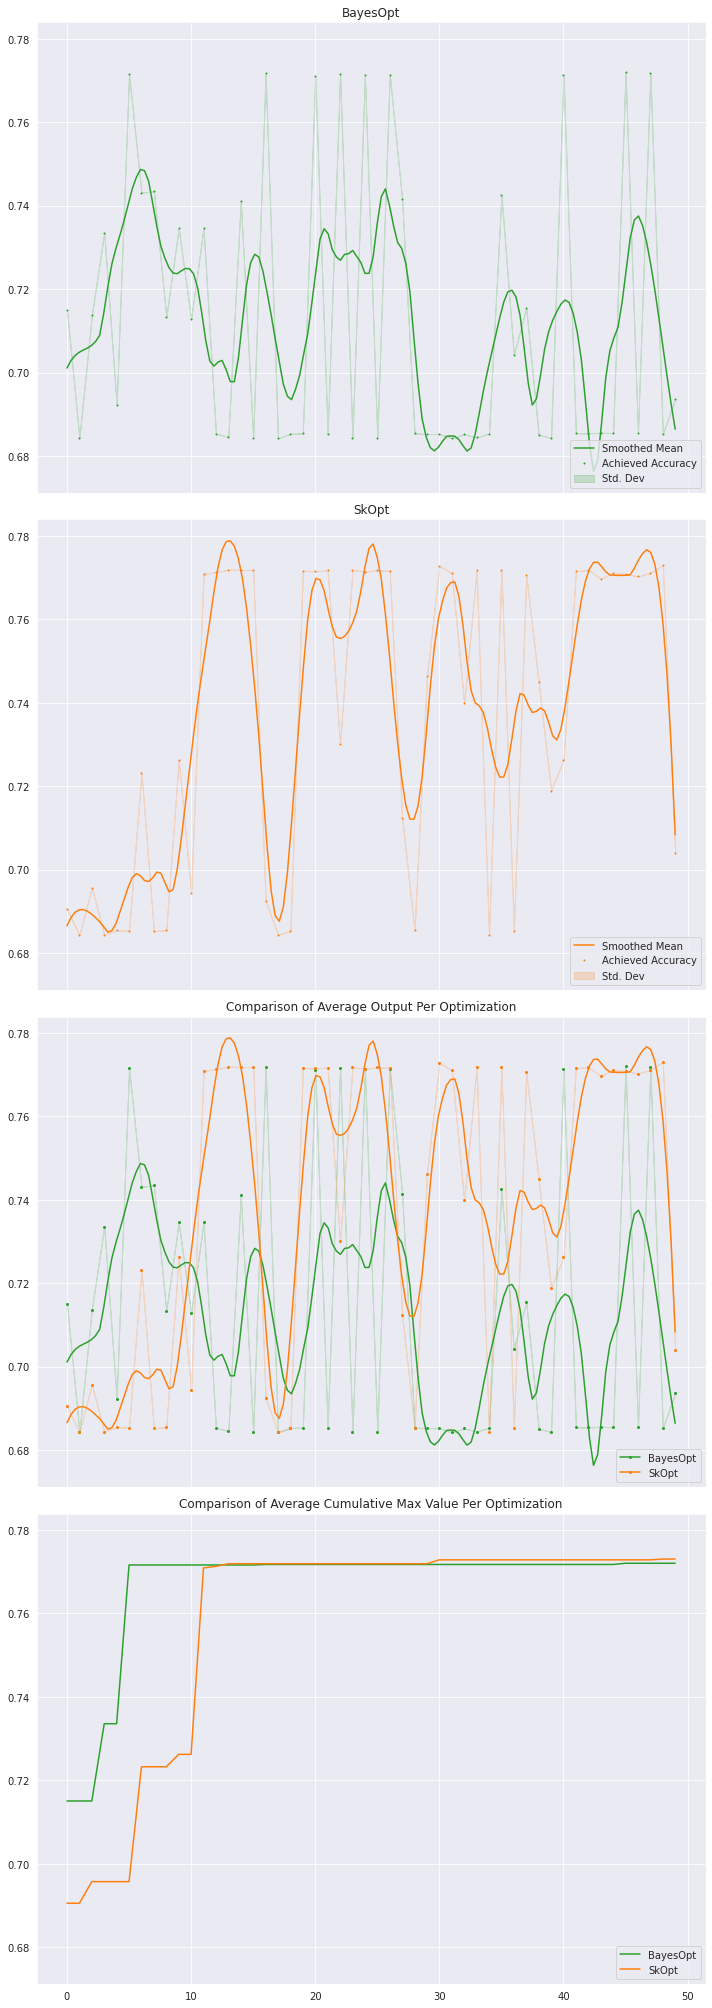

In [22]:
x = np.arange(0, n_rows, 1)
x_smoothed = np.linspace(x.min(), x.max(), 150)

sns.set_style("darkgrid")


fig, axes = None, None
if len(combined_dfs) == 2:
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(10, 28))
elif len(combined_dfs) == 1:
    fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 28))
all_axes = {}
i = 0
for key in combined_dfs.keys():
    all_axes[key] = axes[i]
    i += 1
all_axes["All"] = axes[i]
i += 1
all_axes["Max"] = axes[i]

comb_axes = axes[i - 1]
max_axes = axes[i]

colors = {
    "BayesOpt": "C2",
    "SkOpt": "C1",
}

comb_legend_handles = []
max_legend_handles = []

for name, df in combined_dfs.items():
    df = df[:n_rows]
    ymean = df["Mean"]
    ystd = df["Std"]
    ystd_up = df["Upper"]
    ystd_dn = df["Lower"]

    ax = all_axes[name]

    # Smooth the means to make it easier to read
    itp = interp1d(x, ymean, kind="linear")
    window_size, poly_order = 17, 3
    ymean_smoothed = savgol_filter(itp(x_smoothed), window_size, poly_order)

    ax.plot(x_smoothed, ymean_smoothed, "-", color=colors[name])
    ax.plot(x, df["test_accuracy"], "o", color=colors[name], markersize=1.0)
    ax.fill_between(x, ystd_up, ystd_dn, alpha=0.2, color=colors[name])
    ax.set_title(name)

    mean_line = mlines.Line2D(
        [], [], color=colors[name], markersize=1, label="Smoothed Mean"
    )
    points = mlines.Line2D(
        [],
        [],
        color=colors[name],
        marker="o",
        markersize=1,
        linestyle="",
        label="Achieved Accuracy",
    )
    std_patch = mpatches.Patch(color=colors[name], alpha=0.2, label="Std. Dev")
    ax.legend(handles=[mean_line, points, std_patch], loc="lower right")

    comb_axes.set_title("Comparison of Average Output Per Optimization")
    comb_axes.plot(x_smoothed, ymean_smoothed, "-", color=colors[name])
    comb_axes.plot(x, ymean, "o", color=colors[name], markersize=2)
    comb_axes.fill_between(x, ystd_up, ystd_dn, alpha=0.2, color=colors[name])

    comb_legend_handles.append(
        mlines.Line2D([], [], color=colors[name], marker="o", markersize=2, label=name)
    )

    max_axes.set_title("Comparison of Average Cumulative Max Value Per Optimization")
    max_axes.plot(
        x,
        df[["test_accuracy"]].cummax().mean(axis=1),
        "-",
        color=colors[name],
        alpha=1.0,
    )

    max_legend_handles.append(mlines.Line2D([], [], color=colors[name], label=name))

comb_axes.legend(handles=comb_legend_handles, loc="lower right")
max_axes.legend(handles=max_legend_handles, loc="lower right")

fig.tight_layout()

fig.savefig("SearchComparison.png", facecolor="white", transparent=False)

In order to get informative plots, run the notebook with `BayesOpt` once and then with `SkOpt`.

These graphs show the mean accuracy for each trial across multiple runs along with standard deviation.

The comparison graphs show the two different optimizations on the same one to help see how each of them performed at similar points in optimizations.

The last graph shows the cumulative maximum for each trial per optimization. This is useful in understanding which of the optimization techniques arrive at the "best" parameters quickly and how well each of them perform.

## Conclusion and Next Steps
We notice an improvement in performance with just `2500000` rows out of a total 115M available in the dataset. Generally HPO yields better results with larger datasets and wider parameter ranges. It is encouraged to repeat this experiment with different models, swapping out different search and scheduling algorithms to understand how RayTune works. In this notebook, we use a rather basic metric `test_accuracy` for evaluating the performance. You can use a more informative metric or even use a combination of metrics to evaluate. These tweaks can help boost the performance of a model greatly and make HPO quite powerful.

RayTune provides a clean way to run experiments and it provides powerful tools like scheduling algorithms and efficient optimization techniques to help us arrive at the results quicker and in an efficient way. Hopefully, this notebook can serve as a good starting point to explore [RayTune](https://ray.readthedocs.io/en/latest/index.html) + [RAPIDS](https://rapids.ai/) for HPO experiments.

#### Learn More
- [Algorithms for Hyper-Parameter Optimization](http://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)
- [5 Classification Evaluation metrics](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)
- [RayTune Examples](https://github.com/ray-project/ray/tree/master/python/ray/tune/examples)
- [RAPIDS on GitHub](https://github.com/rapidsai)
- Anyscale has series of online events this Summer, called Ray Summit Connect, where you can learn more about Ray. For information, visit the [events page](https://anyscale.com/events)